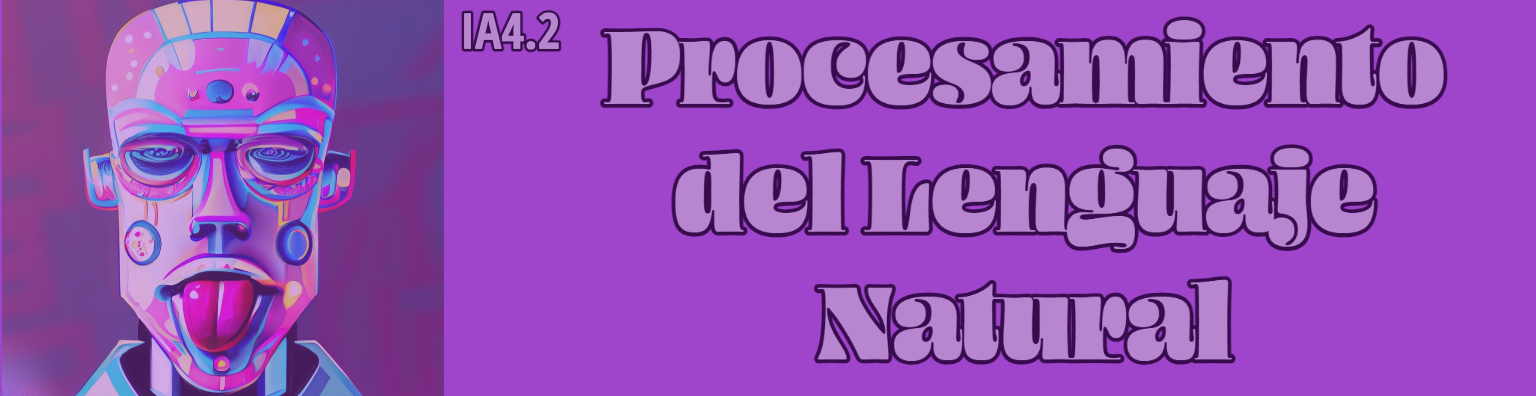

In [21]:
!pip install PyPDF2
!pip install chromadb
!pip install sentence-transformers
!pip install gradio
!pip install sparqlwrapper

In [22]:
!pip install langchain
!pip install langchain_openai
!pip install -U langchain-community

# DOCUMENTO DE TEXTO

## Descarga de Drive y carga de archivos pdf y el .sql en Colab

In [23]:
# Obtenemos los PDFs que usaremos como fuente de conocimiento
import gdown
from langchain.text_splitter import CharacterTextSplitter

# Link con archivos sobre sobre reglamento y estadísticas de mundiales
url = 'https://drive.google.com/drive/folders/1AIZ-tX0YJpT7aszryLZoc6dciPbq7QW6'

# Descarga carpeta 'Archivos TP'
gdown.download_folder(url, quiet=True, output='.')

['./Estadisticas_Mundiales_Basquet.sql',
 './REGLAMENTO_B__SICO_DE_BALONCESTO.pdf',
 './reglamento_basquetbol.pdf',
 './Reglas Oficiales de Baloncesto FIBA 2022_V2.pdf']

## Extracción del texto del pdf

In [24]:
import re
from PyPDF2 import PdfReader

# Funcion para extraer el texto de los pdf
def extraer_texto_pdf(file_path):
    reader = PdfReader(file_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()

    return text

pdf_file_path = 'REGLAMENTO_B__SICO_DE_BALONCESTO.pdf'
documento1 = extraer_texto_pdf(pdf_file_path)

pdf_file_path = 'Reglas Oficiales de Baloncesto FIBA 2022_V2.pdf'
documento2 = extraer_texto_pdf(pdf_file_path)

pdf_file_path = 'reglamento_basquetbol.pdf'
documento3 = extraer_texto_pdf(pdf_file_path)

# Cargar los documentos de texto
documents = [documento1, documento2, documento3]

# Preprocesamiento para eliminar URLs, caracteres no alfanuméricos y el básico
for document in documents:
    document = re.sub(r'http\S+|www\S+|\S+\.\S+', '', document)
    document = "".join([char if char.isalnum() or char.isspace() else ' ' for char in document])

# Imprime el texto extraído
# print(documento1)
# print(documento2)
# print(documento3)


## División del texto, creación de embeddings y almacenamiento en ChromaDB

In [38]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import chromadb
from chromadb.config import Settings

# Configurar la base de datos ChromaDB
client = chromadb.Client(Settings())

# Lista todas las colecciones
collections = client.list_collections()
# Comprueba si la colección existe
collection_exists = any(col.name == "baloncesto_embeddings" for col in collections)

if collection_exists:
  client.delete_collection(name="baloncesto_embeddings")
  print("Se eliminó la colección")

collection = client.create_collection("baloncesto_embeddings")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Tamaño del fragmento
    chunk_overlap=200  # Superposición entre fragmentos
)

embeddings_model = HuggingFaceEmbeddings(model_name='sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

global_id = 0

for document in documents:
  # División del texto
  texts = text_splitter.split_text(document)

  # Impresión de cada fragmento para evaluar
  for i, fragment in enumerate(texts):
    print(f"Fragment {i+1}:\n{fragment}\n{'-' * 40}\n")

  # Creación de embeddings
  embeddings = embeddings_model.embed_documents(texts)
  print(embeddings)

  # Almacenamiento de embeddings
  for text, embedding in zip(texts, embeddings):
    collection.add(documents=[text],
        embeddings=[embedding],
        metadatas=[{"text": text}],
        ids=[str(global_id)]
    )
    global_id += 1  # Incrementa el contador global
  print("Embeddings almacenados en ChromaDB.")

Se eliminó la colección


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Se han truncado las últimas 5000 líneas del flujo de salida.
El primer  entrenador del equipo “A” será el primero que proporcione esta información.
----------------------------------------

Fragment 210:
del jugador en la columna ‘Entrada’.  
 
B.4.4.  Firmará el acta.  
El primer  entrenador del equipo “A” será el primero que proporcione esta información.  
B.5. Al inicio del partido , el anotador rodeará con un círculo la ‘x’ de los 5 jugadores de cada equipo que iniciarán 
el partido.  
B.6. Durante el partido , el anotador trazará una pequeña ‘x’ (sin círculo) en la columna de ‘Entrada’ cuando un 
sustituto se i ncorpore por primera vez al partido como jugador.  
B.7. Tiempos muertos  
B.7.1.  Los tiempos muertos concedidos se anotarán en el acta del partido, debajo del nombre del equipo, 
anotando el minuto de juego del cuarto o de la prórroga en las casillas apropiadas, junto a H1 para la 
primera mitad, junto a H2 para la segunda mitad y junto a OT para hasta 3 prórrogas . 
B.7.

# Datos SQLITE



In [39]:
import sqlite3
con = sqlite3.connect("mundiales_basquet.db")

# Crea un cursor para ejecutar comandos SQL
cursor = con.cursor()

# Genera la tabla si no existe

cursor.execute("CREATE TABLE IF NOT EXISTS mundiales_stats (seleccion VARCHAR(100), puntos INTEGER,\
                jugados INTEGER, ganados INTEGER, perdidos INTEGER, campeon INTEGER, subcampeon INTEGER, \
                tercero INTEGER)")
cursor.execute("DELETE FROM mundiales_stats")

# Abre el archivo "mundiales_stats.sql" que contiene instrucciones SQL
with open('Estadisticas_Mundiales_Basquet.sql', encoding="utf8") as f:
  sql_insterts=f.read()

# Divide las instrucciones SQL en una lista
sql_list = sql_insterts.split(";")
print(len(sql_list))

# Ejecuta cada instrucción SQL en la lista
for sql in sql_list:
    cursor.execute(sql)

# Confirma los cambios en la base de datos
con.commit()

# Cierra la conexión a la base de datos
con.close()


60


In [40]:
# Sólo verifico que estén los datos subidos
con = sqlite3.connect("mundiales_basquet.db")

# Crea un cursor para ejecutar comandos SQL
cursor = con.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='mundiales_stats';")
table_exists = cursor.fetchone()

if table_exists:
    # Realizar la consulta
    cursor.execute('SELECT * FROM mundiales_stats')
    rows = cursor.fetchall()

    if rows:
        # Mostrar los resultados
        for row in rows:
            print(row)
    else:
        print("No hay datos en la tabla mundiales_stats.")
else:
    print("La tabla mundiales_stats no existe.")

# Cerrar la conexión
con.close()

('Estados Unidos', 287, 158, 129, 29, 5, 3, 4)
('Brasil', 224, 140, 84, 56, 2, 2, 2)
('Argentina', 189, 118, 71, 47, 1, 2, 0)
('España', 171, 100, 71, 29, 2, 0, 0)
('Union Soviética', 146, 80, 66, 14, 3, 3, 2)
('Canada', 146, 107, 39, 68, 0, 0, 1)
('Puerto Rico', 138, 98, 40, 58, 0, 0, 0)
('Yugoslavia', 136, 78, 58, 20, 3, 3, 2)
('Australia', 129, 88, 41, 47, 0, 0, 0)
('Italia', 117, 74, 43, 31, 0, 0, 0)
('Grecia', 97, 61, 36, 25, 0, 1, 0)
('Francia', 97, 63, 34, 29, 0, 0, 2)
('Serbia', 84, 50, 34, 16, 2, 2, 0)
('China', 82, 65, 17, 48, 0, 0, 0)
('Lituania', 68, 41, 27, 14, 0, 0, 1)
('Uruguay', 67, 50, 17, 33, 0, 0, 0)
('Angola', 66, 51, 15, 36, 0, 0, 0)
('Rusia', 64, 39, 25, 14, 0, 2, 0)
('Alemania', 64, 41, 23, 18, 1, 0, 1)
('Turquia', 62, 38, 24, 14, 0, 1, 0)
('Corea del Sur', 61, 51, 10, 41, 0, 0, 0)
('Cuba', 53, 35, 18, 17, 0, 0, 0)
('Filipinas', 53, 40, 13, 27, 0, 0, 1)
('México', 52, 35, 17, 18, 0, 0, 0)
('Nueva Zelanda', 52, 37, 15, 22, 0, 0, 0)
('Checoslovaquia', 47, 30, 17, 1

# Generación del objeto chat usando OpenAI

In [41]:
from google.colab import userdata
import os

# Retrieve the secret value
openai_api_key = userdata.get('OPENAI_API_KEY')

# Autenticar tu cuenta de Google
#auth.authenticate_user()

# Importar la librería de secretos de Colab
#from colab_secrets import Secrets
#secrets = Secrets()

# Obtener la clave de API de OpenAI desde los secretos de Colab
#api_key = secrets.get_secret('OPENAI_API_KEY')

# Verificar si la clave se ha recuperado correctamente
#print(api_key)

# Solicitar la clave de API de OpenAI
#os.environ['OPENAI_API_KEY'] = api_key


In [42]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

# Obtener la clave de API del entorno
api_key = os.getenv('OPENAI_API_KEY')

#userdata.get('open_ia_api_key')
#api_key = userdata.get('open_ia_api_key')
chat = ChatOpenAI(temperature=0, openai_api_key=openai_api_key, model="gpt-3.5-turbo")


# GENERACIÓN DE CONTEXTOS SEGÚN LA FUENTE DE DATOS

## Búsqueda en Base Tabular SQLite

In [43]:
def search_in_sql(question: str):


    # Crea una plantilla de prompt para solicitar una consulta SQL
    prompt_template = PromptTemplate.from_template(
       """Eres un experto en SQL y tu tarea es crear una consulta SQL para SQLite sintácticamente correcta y lista para ejecutar \
    para contestar la pregunta dada a continuación. Solo consulta las columnas \
    necesarias para responder la pregunta y alguna adicional que sirva para clarificar la respuesta.

    Presta atención y usa solo los nombres de columna que puedes ver en la tabla que se indica a continuación. Ten especial cuidado de no consultar columnas que no existan.

    La salida sólo debe ser el sql listo para ejecutar.

    Esquema de tabla a consultar: ```mundiales_stats (seleccion VARCHAR(100), puntos INTEGER, jugados INTEGER, ganados INTEGER, perdidos INTEGER, \
    campeon INTEGER, subcampeon INTEGER, tercero INTEGER)```

    Tabla: mundiales_Stats
    Columnas:
    - Selección (char): Indica el pais
    - puntos (integer): Contiene cuántos puntos obtuvo esa selección
    - jugados (integer): Contiene cuántos partidos jugó esa selección
    - ganados (integer): Contiene cuántos partidos ganó esa selección
    - perdidos (integer): Contiene cuántos partidos perdió esa selección
    - campeon (integer): Contiene cuántas veces esa selección salió campeón (cuantos campeonatos ganó)
    - subcampeon (integer): Indica cuántas veces esa selección salió subcampeona
    - tercero (integer): Cuántas veces esa selección salió tercera

    Pregunta: ```{question}```
    """)

    prompt_val = prompt_template.format(question=question)

    # Crea una lista de mensajes para interactuar con el modelo
    messages = [
        SystemMessage(content="Sos un esperto en SQLite"),
        HumanMessage(content=prompt_val),
    ]

    response = chat.invoke(messages)
    sql_query = response.content
    print("SQL Query previo al replace: ", sql_query)
    sql_query = sql_query.replace("sql", "").replace("```", "")

    # Conecta a la base de datos
    con = sqlite3.connect("mundiales_basquet.db")
    cursor = con.cursor()

    print("SQL Query que se ejecuta: ", sql_query)
    try:
      # Ejecuta la consulta

      cursor.execute(sql_query)
      resultado = cursor.fetchall()

      # Obtiene los nombres de las columnas
      columnas = [descripcion[0] for descripcion in cursor.description]

      # Imprime los resultados en formato de texto
      contexto = ""
      for fila in resultado:
        for i in range(len(columnas)):
              contexto = contexto + str(columnas[i]) + ": " + str(fila[i]) + " "
        contexto =  contexto + "\n"



    except Exception as e:
       print(f"An error occurred: {e}")
       contexto = ""
    # Cierra la conexión
    con.close()

    # Procesa la pregunta para identificar palabras clave
    question_modf = ''.join(c for c in question if c.isalnum() or c.isspace())
    palabras_question = question_modf.split()
    sql_query_modif = ''.join(c for c in sql_query if c.isalnum() or c.isspace())
    print("palabras_question: ",palabras_question)

    # Identifica palabras clave en la consulta SQL
    inf_extra_contexto = ""
    for i in palabras_question:
      if i in sql_query_modif:
        inf_extra_contexto += " " + i + " "

    return inf_extra_contexto + contexto
    #return contexto


## Búsqueda en Base de Grafos

In [44]:
from SPARQLWrapper import SPARQLWrapper, JSON

# Configura el punto de acceso SPARQL de Wikidata
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

print("sparql generado: ", sparql)
def get_wikidata_entity_name(wikidata_id):

    # URL del punto de acceso SPARQL de Wikidata
    url = 'https://query.wikidata.org/sparql'

    # Consulta SPARQL para obtener el nombre de la entidad
    query = f'''
    SELECT ?label WHERE
    {{
        SERVICE wikibase:label {{
            bd:serviceParam wikibase:language "en" .
            wd:{wikidata_id} rdfs:label ?label .
        }}
    }}
    '''
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    data = sparql.query().convert()
    return {"label": data["results"]["bindings"][0]["label"]["value"]}



def get_wikidata_description(wikidata_id):
    url = 'https://query.wikidata.org/sparql'
    query = f'''
    SELECT ?description WHERE
    {{
        SERVICE wikibase:label {{
            bd:serviceParam wikibase:language "en" .
            wd:{wikidata_id} schema:description ?description .
        }}
    }}
    '''
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    data = sparql.query().convert()
    # Extrae la descripción de la entidad de los resultados
    return {"description": data["results"]["bindings"][0]["description"]["value"]}

def search_in_wikidata(question: str):
    # Crea una plantilla de prompt para solicitar una consulta SPARQL
    prompt_template = PromptTemplate.from_template(
        """Tu tarea es crear un consulta SPARQL para consultar datos de Wikidata \
        para contestar la pregunta dada a continuación. Es importante que la consulta sea sintáticamente correcto y esté lista para ejecutar.
        Armar la consulta para que el AUTO_LANGUAGE sea español.

        La salida sólo debe ser la consulta SPARQL lista para ejecutar sin ninguna explicación adicional. Siempre limita a máximo 10 registros

        Pregunta: ```{question}```"""
        )
    prompt_val = prompt_template.format(question=question)

    # Crea una lista de mensajes para interactuar con el modelo
    messages = [
        SystemMessage(content="Sos un asistente experto en SPARQL y Wikidata"),
        HumanMessage(content=prompt_val),
    ]

    response = chat.invoke(messages)

    wiki_query = response.content.replace('\n', '').replace("'","").replace("sparql", "").replace("```", "")
    print("wiki_query: ",wiki_query)

    # Realiza la consulta SPARQL a través de la URL del punto de acceso de Wikidata
    try:
      sparql.setQuery(wiki_query)
      sparql.setReturnFormat(JSON)
      results = sparql.query().convert()
      print("results: ",results)

      # Extrae los resultados de la consulta
      #head = results["head"]["vars"][0]

      context = ""

      for data in results["results"]["bindings"]:
          for head in  results["head"]["vars"]:
            if "WHERE" in head:
              continue
            valor = data[head]["value"]
            print("...data: "+ valor + " id? "+str(("http://www.wikidata.org/entity/" in valor)))
            if "http://www.wikidata.org/entity/" in valor:
              id = valor.replace("http://www.wikidata.org/entity/", "")
              try:
                descripcion =  str(get_wikidata_description(id)["description"])
              except:
                descripcion = ""
              context = context + head +": " + str(get_wikidata_entity_name(id)["label"]) + " - " + descripcion + "\n"
            else:
              context = context + head +": " + valor +  "\n"
    except Exception as e:
       print(f"An error occurred: {e}")
       context = ""

    return  context

sparql generado:  <SPARQLWrapper.Wrapper.SPARQLWrapper object at 0x00007CF2D3FE2260>
{"_defaultGraph" : None,
"_defaultReturnFormat" : 'xml',
"agent" : 'sparqlwrapper 2.0.0 (rdflib.github.io/sparqlwrapper)',
"customHttpHeaders" : {},
"endpoint" : 'https://query.wikidata.org/sparql',
"http_auth" : 'BASIC',
"method" : 'GET',
"onlyConneg" : False,
"parameters" : {},
"passwd" : None,
"queryString" : 'SELECT * WHERE{ ?s ?p ?o }',
"queryType" : 'SELECT',
"requestMethod" : 'urlencoded',
"returnFormat" : 'xml',
"timeout" : None,
"updateEndpoint" : 'https://query.wikidata.org/sparql',
"user" : None}


## Búsqueda en Base Vectorial

In [45]:
def search_in_chromadb(question: str):
    # Generar embedding de la consulta
    embedding_consulta = embeddings_model.embed_documents([question])[0]

    # Realizar la consulta en ChromaDB
    results = collection.query(
        query_embeddings=[embedding_consulta],  # Aquí pasamos el embedding de la consulta
        n_results=1  # Traemos el resultado más cercanos
    )

    # Inicializa una cadena para almacenar el contenido de las páginas relacionadas
    context_str = ''
    # Itera sobre los resultados encontrados en la búsqueda de similitud
    for id, doc, distancia in zip(results["ids"], results["documents"], results["distances"]):
        # Agrega el contenido de cada documento al resultado final
        context_str += f"ID: {id}\nDocumento: {doc}\nDistancia: {distancia}\n{'-'*40}\n"

    return context_str

# Ejemplo de uso para probar
# consulta = "¿Cuántos jugadores comenzarán un partido de Basquetbol?"
# resultado = search_in_chromadb(consulta)
# print(resultado)

# CLASIFICADOR

## Basado en un modelo entrenado con ejemplos y embeddings

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sentence_transformers import SentenceTransformer

# Cargamos el modelo desde HuggingFace https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

labels = [(0, "reglamento"), (1, "mundiales de basquetbol"), (2, "otros")]

dataset = []
# textos de "reglamento"
dataset.append((0, "¿De cuántos jugadores pueden ser los equipos?"))
dataset.append((0, "¿A qué altura está colocado el aro para las canastas?"))
dataset.append((0, "¿Cuál es la duración de un partido?"))
dataset.append((0, "¿Cuántos jugadores son en total?"))
dataset.append((0, "¿Cuál es la distancia de la linea de triples?"))
dataset.append((0, "¿Cómo se inicia un partido?"))
dataset.append((0, "¿Cúal es el valor de los tantos en un partido, de acuerdo a la zona de lanzamiento?"))
dataset.append((0, "¿Cuántos pasos como máximo puede dar un jugador con la pelota sin botar?"))
dataset.append((0, "¿Cuántos cambios de jugadores se pueden hacer por equipo en un partido?"))
dataset.append((0, "¿Qué dice la regla de los 5 segundos?"))
dataset.append((0, "¿Se puede pasar atrás la pelota una vez pasada la mitad de la cancha?"))
dataset.append((0, "¿Qué es una falta por contacto?"))

# textos de "mundiales de basquetbol"
dataset.append((1, "¿Cuántas veces salió campeón Brasil?"))
dataset.append((1, "¿Cuántos partidos jugó por el mundial Estados Unidos?"))
dataset.append((1, "¿Cuántas veces salió tercero Uruguay?"))
dataset.append((1, "¿Cuál es la selección que más partidos jugó por mundiales?"))
dataset.append((1, "¿Cuántos partidos ganó Argentina en mundiales?"))
dataset.append((1, "¿Qué país ganó más mundiales y cuántos ganó?"))
dataset.append((1, "¿Cuántas selecciones ganaron mas de 100 partidos por mundiales?"))
dataset.append((1, "¿Qué selección es la que más partidos perdió?"))
dataset.append((1, "¿Algún país salió mas veces subcampeón que campeón?"))
dataset.append((1, "¿Cuántas veces Argentina salió primero, segundo o tercero?"))
dataset.append((1, "¿Chile jugó alguna vez un mundial de basquetbol?"))

# textos de "otros"
dataset.append((2, "Dame una lista de equipos de basquetbol"))
dataset.append((2, "Dame una lista de jugadores de basquetbol"))
dataset.append((2, "Decime el equipo más importante de la NBA"))
dataset.append((2, "¿Qué jugador tiene más anillos de la NBA?"))
dataset.append((2, "¿Cuál es el equipo más importante de Europa?"))
dataset.append((2, "¿Quién fue Emanuel Ginóbili?"))
dataset.append((2, "Listame jugadoras de basquetbol femenino"))
dataset.append((2, "Jugador más importante de la historia"))
dataset.append((2, "¿En qué equipos jugó Luis Scola?"))
dataset.append((2, "Campeones olímpicos"))
dataset.append((2, "Lista de equipos de la NBA"))
dataset.append((2, "Copa del Rey de Basquetbol de España"))
dataset.append((2, "Decime algo de Atenas de Córdoba"))

# Preparar X e y
X = [text.lower() for label, text in dataset]
y = [label for label, text in dataset]

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Obtenemos los embeddings de BERT para los conjuntos de entrenamiento y prueba
X_train_vectorized = model.encode(X_train)
X_test_vectorized = model.encode(X_test)

# Creación y entrenamiento del modelo de Regresión Logística Multinomial
modelo_LR = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
modelo_LR.fit(X_train_vectorized, y_train)

# Evaluación del modelo de Regresión Logística
y_pred_LR = modelo_LR.predict(X_test_vectorized)
acc_LR = accuracy_score(y_test, y_pred_LR)
report_LR = classification_report(y_test, y_pred_LR, zero_division=1)

print("Precisión Regresión Logística:", acc_LR)
print("Reporte de clasificación Regresión Logística:\n", report_LR)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Precisión Regresión Logística: 0.375
Reporte de clasificación Regresión Logística:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.75      0.86         4
           2       1.00      0.00      0.00         4

    accuracy                           0.38         8
   macro avg       0.67      0.58      0.29         8
weighted avg       1.00      0.38      0.43         8



In [47]:
# Nuevas frases para clasificar
new_phrases = [
    "¿Cuánto mide el campo de juego de basquetbol?",
    "¿Cuántas veces salió campeón del mundial de basquet Brasil?",
    "Jugadores Argentinos",
]

# Preprocesamiento y vectorización de las nuevas frases
new_phrases_lower = [text.lower() for text in new_phrases]
new_phrases_vectorized = model.encode(new_phrases_lower)

# Haciendo predicciones con el modelo entrenado
new_predictions = modelo_LR.predict(new_phrases_vectorized)

# Mostrando las predicciones junto con las frases
for text, label in zip(new_phrases, new_predictions):
    print(f"Texto: '{text}'")
    print(f"Clasificación predicha: {labels[label][1]}\n")

Texto: '¿Cuánto mide el campo de juego de basquetbol?'
Clasificación predicha: otros

Texto: '¿Cuántas veces salió campeón del mundial de basquet Brasil?'
Clasificación predicha: otros

Texto: 'Jugadores Argentinos'
Clasificación predicha: reglamento



## Basado en LLM

In [48]:
def clasificador(question: str):
     # Crea un objeto PromptTemplate con una plantilla predefinida para el clasificador.
    prompt_template = PromptTemplate.from_template(
        """Tu tarea es clasificar la pregunta que se te indica a continuación entre las siguientes tres categorias [reglamento, mundiales de basquetbol, otros]

    La respuesta sólo debe ser una de las tres categorias sin otro texto.

    Pregunta: ```{question}```
    """)
    # Formatea la plantilla con la pregunta
    prompt_val = prompt_template.format(question=question)
    # Crea una lista de mensajes con un mensaje del sistema y un mensaje del usuario con la pregunta formateada.
    messages = [
        SystemMessage(content="Sos un experto en temas de deporte, especialmente en baloncesto y ayudas a un asistente virtual a encontrar el contexto adecuado para contestar preguntas."),
        HumanMessage(content=prompt_val),
    ]
    # Llama al modelo de chat con los mensajes y obtiene la respuesta
    response = chat.invoke(messages)

    return response.content

# Generador de Respuesta

In [49]:
def generar_respuesta(query: str, context: str, qtype: str):

# Si no pongo "de manera precisa, me devuelve mal la información de la base de datos tabular y si lo pongo me devuelve mal la información de wikidata"
  if qtype == "otros":
      prompt_template = PromptTemplate.from_template(
          """Contexto de Grafos:
          {context_str}

          Basándote en la información del contexto anterior, responde la siguiente pregunta de la manera más precisa posible.

          Pregunta: {query_str}
          """
      )

  else:
      prompt_template = PromptTemplate.from_template(
       """La siguiente es la información de contexto relevante:\n"
       "{context_str}"
       "\nUtilizando únicamente la información de contexto anterior y sin mencionarla en la respuesta, responde de manera precisa a la siguiente pregunta.\n"
       "Pregunta: {query_str}"""
      )

  # Formatea la plantilla con la pregunta y el contexto
  prompt_val = prompt_template.format(query_str=query, context_str=context)
  print("prompt_val: ", prompt_val)
  # Crea una lista de mensajes con un mensaje del sistema y un mensaje del usuario con la pregunta y el contexto formateados.
  messages = [
      SystemMessage(content="Eres un asistente útil que siempre responde con respuestas veraces, útiles y basadas en hechos. Responde siempre basándote en los hechos dados en el contexto."),
      HumanMessage(content=prompt_val),
  ]
  # Llama al modelo de chat con los mensajes y obtiene la respuesta
  print("messages: ", messages)
  response = chat.invoke(messages)
  print("response: ", response)
  return response.content

# CHATBOT

In [50]:
from langchain.prompts import PromptTemplate
import gradio as gr

# Usa una interfaz de ChatInterface para el chat
def chat_response(query, history):
    # Usa la función clasificador para definir la categoría de la pregunta
    qtype = clasificador(query)
    print("qtype: ", qtype)
    context = ""
    if qtype == "reglamento":
      context = search_in_chromadb(query)
      print(context)
    elif qtype == "mundiales de basquetbol":
      context = search_in_sql(query)
    else:
      context = search_in_wikidata(query)

    print("Contexto: ", context)
    print("Query: ", query)
    response = generar_respuesta(query, context, qtype)

    return  response

demo = gr.ChatInterface(fn = chat_response,examples=["¿Cuál es la seleccion que salió campeón mas veces y cuantas veces ganó?",
                                                     "Listame equipos de Basquetbol de España",
                                                     "¿Cuánto mide de largo la cancha de basquet?",
                                                     "¿Cuántos veces salió campeón del mundial de basquet Brasil?",
                                                     "¿Cuántos jugadores comenzarán un partido de Basquetbol?",
                                                     "Jugadores de Basquetbol"] ,title = ' CHATBOT DE BALONCESTO '
                                                     , chatbot=gr.Chatbot(value=[(None, "¡¡¡Hola!!! Soy un chatbot especializado en Basquetbol. Puedo ayudarte a resolver dudas sobre el reglamento, estadísticas de mundiales y otros temas relacionados.")]))

demo.launch(debug=True)
#demo.launch(debug=False)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://5b8462e47fd59df5cc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


qtype:  mundiales de basquetbol
SQL Query previo al replace:  ```sql
SELECT seleccion, campeon
FROM mundiales_stats
ORDER BY campeon DESC
LIMIT 1;
```
SQL Query que se ejecuta:  
SELECT seleccion, campeon
FROM mundiales_stats
ORDER BY campeon DESC
LIMIT 1;

palabras_question:  ['Cuál', 'es', 'la', 'seleccion', 'que', 'salió', 'campeón', 'mas', 'veces', 'y', 'cuantas', 'veces', 'ganó']
Contexto:   es  seleccion seleccion: Estados Unidos campeon: 5 

Query:  ¿Cuál es la seleccion que salió campeón mas veces y cuantas veces ganó?
prompt_val:  La siguiente es la información de contexto relevante:
"
       " es  seleccion seleccion: Estados Unidos campeon: 5 
"
       "
Utilizando únicamente la información de contexto anterior y sin mencionarla en la respuesta, responde de manera precisa a la siguiente pregunta.
"
       "Pregunta: ¿Cuál es la seleccion que salió campeón mas veces y cuantas veces ganó?
messages:  [SystemMessage(content='Eres un asistente útil que siempre responde con respue